In [ ]:
%load_ext snakeviz

In [ ]:
from typing import Iterable
from nilearn import plotting
from nilearn import datasets

In [ ]:
import nibabel as nib
import numpy as np

In [ ]:
from neurolang import frontend as fe

from nilearn.datasets import utils
import pandas as pd

# Prepare NeuroSynth 

In [ ]:
d_neurosynth = utils._get_dataset_dir('neurosynth', data_dir='neurolang_data')

f_neurosynth = utils._fetch_files(
    d_neurosynth, [
        (
            f,
            'https://github.com/neurosynth/neurosynth-data/raw/master/current_data.tar.gz',
            {'uncompress': True}
        )
        for f in ('database.txt', 'features.txt')
    ],
    verbose=True
)

database = pd.read_csv(f_neurosynth[0], sep='\t')
features = pd.read_csv(f_neurosynth[1], sep='\t')

features_normalised = (
    features
    .melt(id_vars=features.columns[0], var_name='term', value_vars=features.columns[1:], value_name='tfidf')
    .query('tfidf > 0')
)



In [ ]:
nsh = fe.neurosynth_utils.NeuroSynthHandler()
ns_ds = nsh.ns_load_dataset()
it = ns_ds.image_table
vox_ids, study_ids_ix = it.data.nonzero()
study_ids = ns_ds.image_table.ids[study_ids_ix]
study_id_vox_id = np.transpose([study_ids, vox_ids])
masked_ = it.masker.unmask(np.arange(it.data.shape[0]))
nnz = masked_.nonzero()
vox_id_MNI = np.c_[
    masked_[nnz].astype(int),
    nib.affines.apply_affine(it.masker.volume.affine, np.transpose(nnz)),
    [
        fe.ExplicitVBR(
            [v],
            affine_matrix=it.masker.volume.affine,
            image_dim=it.masker.volume.shape
        )
        for v in zip(*nnz)
    ]
]

# Initialise and load the fronte-end

In [ ]:
nl = fe.NeurolangDL()

@nl.add_symbol
def agg_count(x: Iterable) -> int:
    return len(x)

@nl.add_symbol
def agg_sum(x: Iterable) -> float:
    return x.sum()

@nl.add_symbol
def agg_mean(x: Iterable) -> float:
    return x.mean()

ns_pmid_term_tfidf = nl.add_tuple_set(features_normalised.values, name='ns_pmid_term_tfidf')
ns_activations = nl.add_tuple_set(database[['id', 'x', 'y', 'z', 'space']].values, name='ns_activations')
ns_activations_by_id = nl.add_tuple_set(
    study_id_vox_id, name='ns_activations_by_id'
)
ns_vox_id_MNI = nl.add_tuple_set(vox_id_MNI, name='ns_vox_id_MNI')

## Forward inference on term "Auditory"

In [12]:
with nl.scope as e:
    e.term_docs[e.term, e.pmid] = (
        ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf] &
        (e.term == 'auditory') &
        (e.tfidf > 1e-3)        
    )

    e.act_term_counts[e.term, e.voxid, agg_count(e.pmid)] = (
        ns_activations_by_id[e.pmid, e.voxid] &
        e.term_docs[e.term, e.pmid]
    )    

    e.term_counts[e.term, agg_count(e.pmid)] =  (
        ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf] &
        e.term_docs[e.term, e.pmid]
    )
 
    e.p_act_given_term[e.voxid, e.x, e.y, e.z, e.term, e.prob] = (
        e.act_term_counts[e.term, e.voxid, e.act_term_count] &
        e.term_counts[e.term, e.term_count] &
        e.ns_vox_id_MNI[e.voxid, e.x, e.y, e.z] &
        (e.prob == (e.act_term_count / e.term_count))
    )
    res = nl.solve_all()

/Users/dwasserm/sources/NeuroLang/neurolang/datalog/aggregation.py:139: UserWarning: No check performed. Should implement check for stratified aggregation
  warn(
/Users/dwasserm/anaconda/envs/root3.8-neurosynth/lib/python3.8/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Users/dwasserm/anaconda/envs/root3.8-neurosynth/lib/python3.8/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


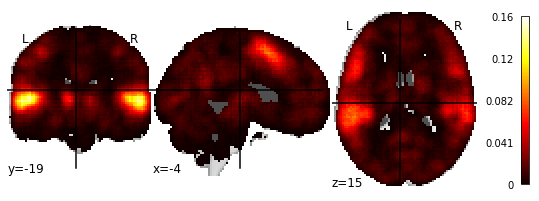

In [9]:
mni_t1 = it.masker.volume

ijk_coords = tuple(
    (
        np.round(
            nib.affines.apply_affine(
                np.linalg.inv(mni_t1.affine),
                res['p_act_given_term'].unwrap().as_numpy_array()[:, 1:4]
            ).astype(float).T
        ).T
    ).astype(int).T
)

res_img = np.zeros(mni_t1.shape)
res_img[ijk_coords] = res['p_act_given_term'].unwrap().as_numpy_array()[:, -1]

res_sp = nib.spatialimages.SpatialImage(
    dataobj=res_img, affine=mni_t1.affine
)

plotting.plot_stat_map(res_sp)

## Reverse Inference Terms Associated with Voxels Associated with "Auditory"

In [10]:
r = res['p_act_given_term'].unwrap()
thresh_voxels = r.selection(lambda x: x[5] > .12)

In [11]:
auditory_voxels_prob = nl.add_tuple_set(thresh_voxels.as_numpy_array(), name='auditory_voxels_prob');

In [ ]:
%%snakeviz
with nl.scope as e:
    e.term_docs[e.term, e.pmid] = (
        ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf] &
        (e.tfidf > 1e-3)        
    )

    e.term_counts[e.term, agg_count(e.pmid)] =  (
        ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf] &
        e.term_docs[e.term, e.pmid]
    )
    e.act_counts[e.voxid, agg_count(e.pmid)] = ns_activations_by_id[e.pmid, e.voxid]
    
    e.quantity_docs[agg_count(e.pmid)] = ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf]
    
    e.act_prob[e.voxid, e.prob] = (
        e.act_counts[e.voxid, e.count] &
        e.quantity_docs[e.q] &
        (e.prob == e.count / e.q)
    )
    
    e.act_term_counts[e.voxid, e.term, agg_count(e.pmid)] = (
        auditory_voxels_prob[e.voxid, e.x, e.y, e.z, e.term_, e.prob_] &
        e.term_docs[e.term, e.pmid] &
        ns_activations_by_id[e.pmid, e.voxid]
    )

    e.p_term_given_act[e.term, e.voxid, e.prob] = (
        e.act_term_counts[e.voxid, e.term, e.act_term_count] &
        e.act_counts[e.voxid, e.act_count] &
        (e.prob == e.act_term_count / e.act_count)
    )
    
    e.e_term_given_aud_act[e.term, agg_sum(e.p)] = (
        e.p_term_given_act[e.term, e.voxid, e.prob] & 
        e.act_prob[e.voxid, e.act_prob_] &
        (e.p == e.prob * e.act_prob_)    
    )
    
    res = nl.solve_all()

/Users/dwasserm/sources/NeuroLang/neurolang/datalog/aggregation.py:139: UserWarning: No check performed. Should implement check for stratified aggregation
  warn(


In [ ]:
res['e_term_given_aud_act']

In [ ]:
c = res['e_term_given_aud_act']._container.copy()

### Keep the terms that are on the top 1%

In [ ]:
c[1].hist();

In [ ]:
c[c[1] >= c[1].quantile(.99)].sort_values(1, ascending=False)